Simulation Studies based on 3.1 of

["High Dimensional Minimum Variance Portfolio Estimation under Statistical Factor Models (SSRN)"](https://deliverypdf.ssrn.com/delivery.php?ID=710087064097089099075122013076085122015017095012001064108080022002087011024122090093101099062003019016045100088113097096010030007087059020059073071069024006119082065001078078026082127072023073100117119073095071000127101006070077004025012073031126000105&EXT=pdf&INDEX=TRUE)


[Published verson at JoE](https://www.sciencedirect.com/science/article/abs/pii/S0304407620302037)

In [ ]:
!pip install bs4 > NUL
!pip install yfinance > NUL

In [52]:
import numpy as np
import pandas as pd
import requests
import bs4 as bs
import datetime
import random
import yfinance as yf
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from scipy.stats import multivariate_normal
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV, LedoitWolf, ShrunkCovariance, OAS

In [57]:
def generate_multivariate_returns(sample_size,
                                  start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                  number_of_companies=None, seed=None, plot_covRe=True, plot_covU=True, plot_cov_rv=True,
                                  plot_random_series=True, covariance_method='graphicallassocv'):
    """
    Generates a multivariate returns series from a multivariate normal distribution MVN(0,covRe) with zero means and an
    estimated covariance matrix: covRe = sigma2_m * B @ B.T + covU based on historical data for the S&P 100 Index.
    We fit CAPM to the daily returns of each stock to get the coefficients B, and the covU is obtained by applying the
    shrinkage and soft-thresholding method (Rothman (2012)) to the sample covariance matrix of the residuals from fitting CAPM.
    Copyright (C) 2023 Ali Habibnia <habibnia@vt.edu>

    Parameters:
    - sample_size: int, Number of samples for the return series
    - start_date: datetime, Start date for the data collection (default is 2004-01-01)
    - end_date: datetime, End date for the data collection (default is 2016-01-01)
    - number_of_companies: int, Number of randomly selected companies from S&P 100 that shows
       the dimension of the portfolio (default includes all companies in s&p 100)
    - seed: int, Random seed for reproducibility (default is None)
    - plot_covRe: bool, Whether to plot the heatmap of the estimated covariance for returns (covRe) (default is False)
    - plot_covU: bool, Whether to plot the heatmap of the covariance of residuals (covU) (default is False)
    - plot_cov_rv: bool, Whether to plot the heatmap of the covariance of generated random variables (rv) (default is False)
    - covariance_method (str, optional): The shrinkage and soft-thresholding method used to compute covU.
        Options include 'lw' for Ledoit-Wolf estimator, 'sc' for Shrunk covariance estimator, 'oas' for Oracle Approximating
        Shrinkage estimator, 'pds' for Positive definite sparse estimator, and 'graphicallassocv' for GraphicalLassoCV (default method).

    Returns:
    - DataFrame containing the generated multivariate returns series
    """
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Getting the S&P 100 tickers from Wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = [row.findAll('td')[0].text.replace('\n', '') for row in table.findAll('tr')[1:]]
    if seed is not None:
        np.random.seed(seed)
    if number_of_companies is not None:
        tickers = np.random.choice(tickers, number_of_companies, replace=False)
    tickers += ["^OEX"] # Include S&P 100 index

    # Downloading data
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    cleaned_data = data.dropna(axis='columns', how='any').dropna(axis='index', how='any')
    Re = (np.log(cleaned_data.iloc[:, :-1]) - np.log(cleaned_data.iloc[:, :-1].shift(1))).dropna()

    # Reading factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=start_date, end=end_date)[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT'] / 100

    # Compute CAPM and residuals
    coeffs = np.empty((Re.shape[1],1))
    residuals = np.empty((len(Re), 0))
    for i in range(Re.shape[1]):
        df_stk = Re.iloc[:, i]
        df_stock_factor = pd.merge(df_stk, df_factors, left_index=True, right_index=True)
        df_stock_factor['XsRet'] = df_stock_factor.iloc[:, 0] - df_stock_factor['RF']
        CAPM = sm.ols(formula='XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        coeffs[i] = CAPM.params[1]
        residuals = np.hstack((residuals, CAPM.resid.values.reshape(-1, 1)))

    # Estimation of covU, sigma2_m, and covRe

    # Compute covU based on the selected method
    if covariance_method == 'lw':
        lw = LedoitWolf().fit(residuals)
        covU = lw.covariance_
    elif covariance_method == 'sc':
        sc = ShrunkCovariance().fit(residuals)
        covU = sc.covariance_
    elif covariance_method == 'oas':
        oas = OAS().fit(residuals)
        covU = oas.covariance_
    elif covariance_method == 'pds':
        sc = ShrunkCovariance().fit(residuals)
        oas = OAS().fit(residuals)
        alpha = 0.5  # regularization parameter
        covU = alpha * np.abs(sc.covariance_) + (1 - alpha) * oas.covariance_
    elif covariance_method == 'graphicallassocv':
        model_cov = GraphicalLassoCV()
        covU = model_cov.fit(residuals).covariance_
    else:
        raise ValueError(f"Unknown covariance_method: {covariance_method}")
    sigma2_m = np.var(df_factors['MKT'])
    B = coeffs.reshape(-1, 1)
    covRe = sigma2_m * B @ B.T + covU  # Estimated covariance matrix for returns

    # Generate multivariate returns
    rv = multivariate_normal(mean=np.zeros(len(covRe)), cov=covRe)
    multivariate_returns = rv.rvs(size=sample_size)

    # Convert to DataFrame
    return_series = pd.DataFrame(multivariate_returns, columns=[f'Asset_{i}' for i in range(1, len(covRe) + 1)])

    # Plot heatmaps if required
    if plot_covRe:
        sns.heatmap(covRe)
        plt.title("Estimated Covariance of Returns (covRe)")
        plt.show()

    if plot_covU:
        sns.heatmap(covU)
        plt.title("Covariance of Residuals (covU)")
        plt.show()

    if plot_cov_rv:
        sns.heatmap(np.cov(multivariate_returns, rowvar=False))
        plt.title("Covariance of Generated Random Variables (rv)")
        plt.show()

    # Plot generated random series if required
    if plot_random_series:
        return_series.plot(title="Generated Random Series", figsize=(12,6), legend=False)
        plt.show()

    # Print head of return series
    print(return_series.head())

    return return_series


[*********************100%***********************]  102 of 102 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1072933200, endDate = 1451624400")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


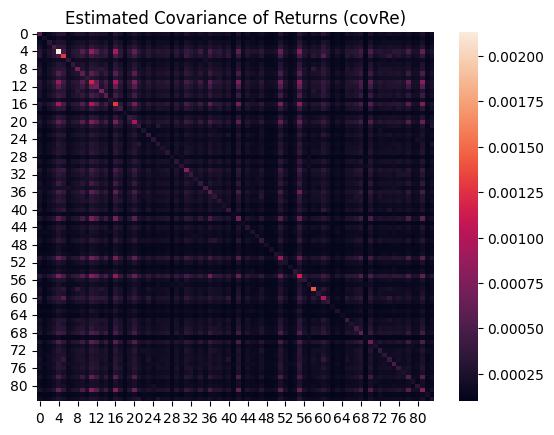

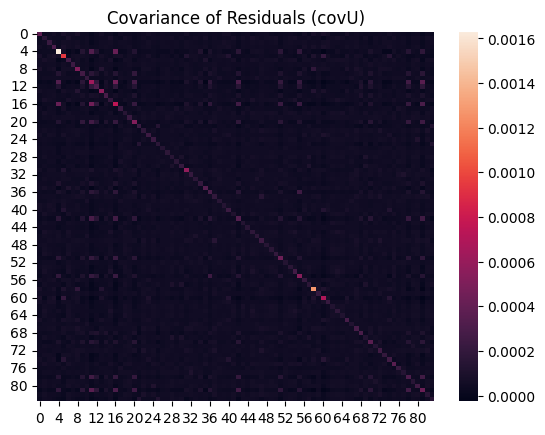

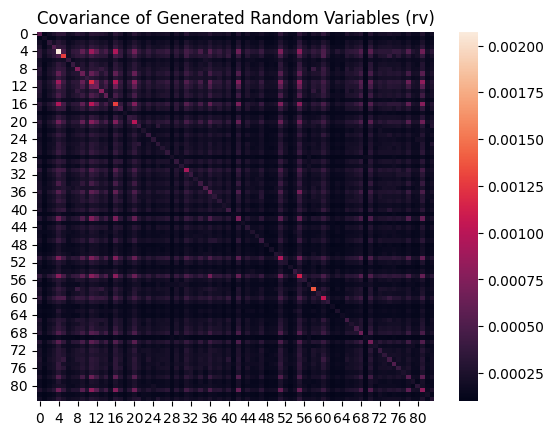

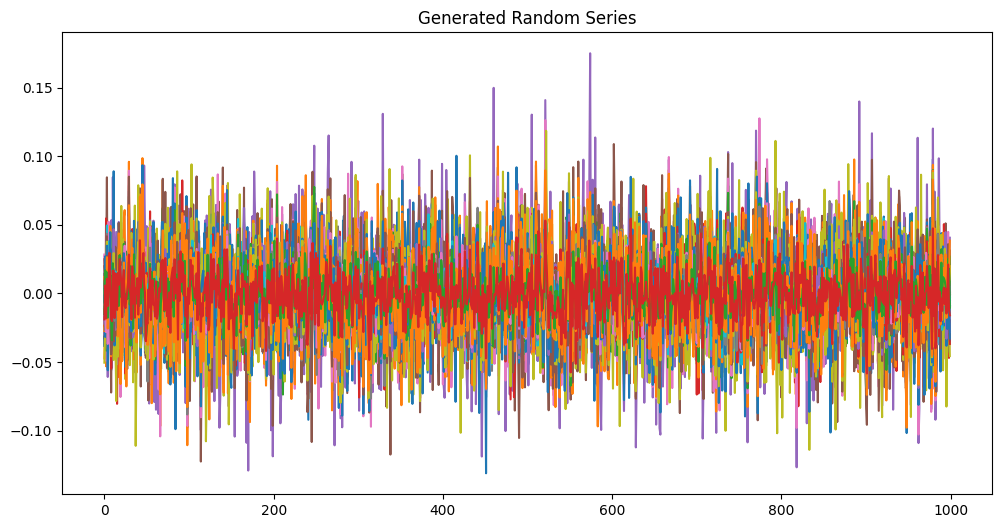

    Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6   Asset_7  \
0 -0.033414  0.002915 -0.000662  0.012089 -0.029777  0.001858 -0.005604   
1  0.002933 -0.013900 -0.007120 -0.002139 -0.004378 -0.011674  0.023319   
2 -0.032136 -0.009728 -0.017867 -0.017503 -0.046249  0.010493  0.004241   
3  0.027392  0.002299  0.002561  0.014884  0.019981  0.084714  0.000021   
4 -0.020402 -0.010230 -0.008629 -0.019611 -0.041666 -0.039229 -0.016313   

    Asset_8   Asset_9  Asset_10  ...  Asset_75  Asset_76  Asset_77  Asset_78  \
0  0.002918 -0.031846 -0.006323  ... -0.014077  0.024937 -0.008472 -0.012471   
1  0.013123 -0.029971  0.003294  ... -0.020047 -0.001597 -0.011658 -0.006779   
2 -0.001938  0.010234 -0.022863  ... -0.024362  0.020706 -0.028161 -0.004980   
3  0.032953  0.042538  0.048308  ...  0.005684  0.027046  0.023850  0.001579   
4 -0.054208 -0.039122 -0.051911  ... -0.011277 -0.009462 -0.036774 -0.005658   

   Asset_79  Asset_80  Asset_81  Asset_82  Asset_83  Asset_84  
0 -0

In [58]:
sample1000 = generate_multivariate_returns(1000,seed=1234 , covariance_method='lw')

### Simiulation

Comparison of various MVP estimators. The mean and standard deviation (in parentheses) based on 1,000 replications of the Relative Risk ratio of estimated MVPs are reported. The number of assets is N = 84 and the sampling sizes are T = 50, 100
and 200. Monte Carlo with the assumption of normality.